In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init


from torch.utils.data import Dataset, DataLoader

Data generation: You are tasked with generating simulated data to represent
microscopic images of subjects, some of whom have been diagnosed with cancer. The
data generation process involves creating a 32x32 matrix for each subject to simulate
microscopic images, using the following specifications:
For each subject, a label 𝑦𝑖
indicates the presence (1) or absence (0) of cancer. This label
is generated using a Bernoulli distribution with a probability of 0.5. The image matrix 𝑿𝒊
for each subject is produced as
𝑿𝒊 = 𝑩𝒊 + 𝝐𝒊
,
where 𝑩𝒊
represents the signal matrix and 𝜖𝑖
is random noise following a normal
distribution 𝑁(0, 0.04). The signal matrix 𝑩𝒊
is generated by first determining the
number of macrovesicle pixels 𝑚𝑖 using a Poisson distribution with parameters
dependent on the subject's cancer status, and then randomly assigning these pixels in the
matrix:


Determine the number of macrovesicle pixels m_i using a poisson distribution with parameters dependent on subject cancer status, and then randomly assigning these pixels in the matrix:

• Generate number of macrovesicle pixels 𝑚𝑖: 𝑚𝑖 follows Poisson distribution with parameter 𝜇𝑐𝑦𝑖 + 𝜇𝑛(1 − 𝑦𝑖). In other words, if the 𝑖 th subject has cancer, its associated 𝑚𝑖 follows Poisson(𝜇𝑐); Otherwise, its associated 𝑚𝑖
follows Poisson(𝜇𝑛). For this simulation, we consider 𝜇𝑛 = 5, and 𝜇𝑐 = 10, 20, 30, respectively.

• Randomly select 𝑚𝑖 pixels from 𝑩𝒊 as 1, and set all other pixels as 0.

In [2]:
def simulateData(n, mu_c, mu_n):

    y = np.random.choice([0, 1], size = n, p = [0.5, 0.5])
    m_i = np.random.poisson(lam = mu_c, size = n) * y + np.random.poisson(lam = mu_n, size = n) * (1 - y)

    simulated_data = np.zeros([n, 32, 32])
    for i in range(n):
        random_indices = np.random.choice(32 * 32, m_i[i], replace = False)
        row_indices, col_indices = np.unravel_index(random_indices, (32, 32))
        Bi = np.zeros([32, 32])
        Bi[row_indices, col_indices] = 1
        epsilon_i = np.random.normal(loc = 0, scale = np.sqrt(0.04), size = (32, 32))
        simulated_data[i] = Bi + epsilon_i

    return y, simulated_data

In [3]:
n = [200, 500, 1000, 200, 500, 1000, 200, 500, 1000]
mu_n = [5, 5, 5, 5, 5, 5, 5, 5, 5]
mu_c = [10, 10, 10, 20, 20, 20, 30, 30, 30]

In [4]:
simulated_datasets_list = []
simulated_y_list = []
for i in range(9):

    y, simulated_data = simulateData(n = n[i],
                                     mu_c = mu_c[i],
                                     mu_n = mu_n[i])
    
    simulated_datasets_list.append(simulated_data)
    simulated_y_list.append(y)

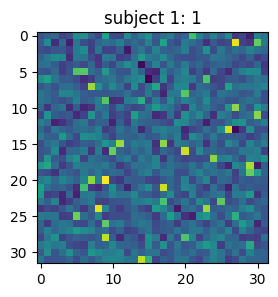

In [5]:
subject = 0
plt.figure(figsize=(3, 3))
plt.imshow(simulated_datasets_list[8][subject, :, :])
plt.title('subject ' + str(subject + 1) + ': ' + str(y[subject]))
plt.show()

### Question 1

Data visualization: Visualize the generated images for settings 1, 4, and 7. For each
setting, display one image from a subject without cancer 𝑦𝑖 = 0 and one from a subject
with cancer 𝑦𝑖 = 1. In total, six images should be visualized, highlighting the differences
in the simulated microscopic images between normal and cancerous subjects.

#### Setting 1: (N 𝜇𝑛 𝜇c) = (200 5 10)

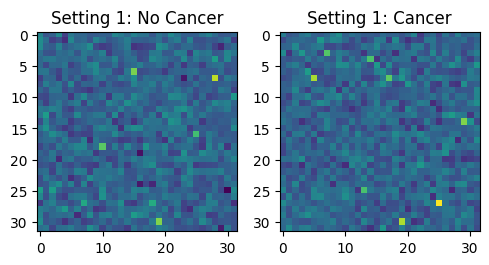

In [6]:
setting1_data = simulated_datasets_list[0]
setting1_y = simulated_y_list[0]

indices_0_y = np.where(setting1_y == 0)
setting1_example_0 = setting1_data[indices_0_y][0, :, :]

indices_1_y = np.where(setting1_y == 1)
setting1_example_1 = setting1_data[indices_1_y][0, :, :]

min_range = np.min([setting1_example_0.min(), setting1_example_1.min()])
max_range = np.max([setting1_example_0.max(), setting1_example_1.max()])

plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.imshow(setting1_example_0, vmin=min_range, vmax=max_range)
plt.title('Setting 1: No Cancer')

plt.subplot(1, 2, 2)
plt.imshow(setting1_example_1, vmin=min_range, vmax=max_range)
plt.title('Setting 1: Cancer')

plt.tight_layout()

#### Setting 4: (N 𝜇𝑛 𝜇c) = (200 5 20)

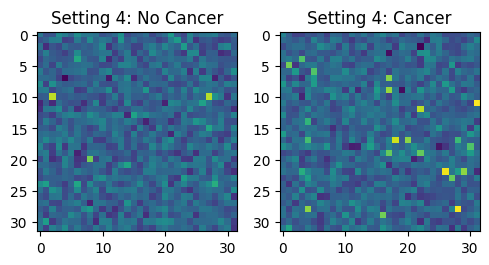

In [7]:
setting4_data = simulated_datasets_list[3]
setting4_y = simulated_y_list[3]

indices_0_y = np.where(setting4_y == 0)
setting4_example_0 = setting4_data[indices_0_y][0, :, :]

indices_1_y = np.where(setting4_y == 1)
setting4_example_1 = setting4_data[indices_1_y][0, :, :]

min_range = np.min([setting4_example_0.min(), setting4_example_1.min()])
max_range = np.max([setting4_example_0.max(), setting4_example_1.max()])

plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.imshow(setting4_example_0, vmin=min_range, vmax=max_range)
plt.title('Setting 4: No Cancer')

plt.subplot(1, 2, 2)
plt.imshow(setting4_example_1, vmin=min_range, vmax=max_range)
plt.title('Setting 4: Cancer')
plt.tight_layout()

#### Setting 7: (N 𝜇𝑛 𝜇c) = (200 5 30)

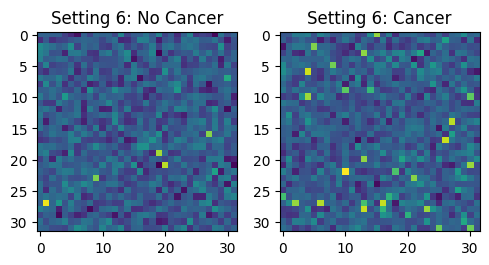

In [8]:
setting7_data = simulated_datasets_list[6]
setting7_y = simulated_y_list[6]

indices_0_y = np.where(setting7_y == 0)
setting7_example_0 = setting7_data[indices_0_y][0, :, :]

indices_1_y = np.where(setting7_y == 1)
setting7_example_1 = setting7_data[indices_1_y][0, :, :]

min_range = np.min([setting7_example_0.min(), setting7_example_1.min()])
max_range = np.max([setting7_example_0.max(), setting7_example_1.max()])

plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.imshow(setting7_example_0, vmin=min_range, vmax=max_range)
plt.title('Setting 6: No Cancer')

plt.subplot(1, 2, 2)
plt.imshow(setting7_example_1, vmin=min_range, vmax=max_range)
plt.title('Setting 6: Cancer')
plt.tight_layout()

### Question 2

CNN training: Train a Convolutional Neural Network on the simulated data for each of
the nine simulation settings. The goal is to use the CNN to predict the cancer status 𝑦𝑖
based on the simulated images 𝑋𝑖
. Additionally, generate a test set of 1000 subjects using
the same data generation process and evaluate the CNN's performance in terms of
classification accuracy. You are free to build a CNN with arbitrary hyperparameter
setting. Conduct at least 10 independent experiments for each setting by generating new
datasets each time, and report the hyperparameters for the CNN, the mean and standard
deviation of the classification accuracy achieved by your CNN model.


#### Data Simulation: Train, Validation, and Test sets
Make test set for each one now. I am also going to make a validation set, the same size as the training set!

In [9]:
n_test = 1000
n = [200, 500, 1000, 200, 500, 1000, 200, 500, 1000]
mu_n = [5, 5, 5, 5, 5, 5, 5, 5, 5]
mu_c = [10, 10, 10, 20, 20, 20, 30, 30, 30]

In [10]:
simulated_val_datasets_list = []
simulated_val_y_list = []
for i in range(9):

    y, simulated_data = simulateData(n = n[i],
                                     mu_c = mu_c[i],
                                     mu_n = mu_n[i])
    
    simulated_val_datasets_list.append(simulated_data)
    simulated_val_y_list.append(y)
simulated_datasets_list[0].shape, simulated_val_datasets_list[0].shape

((200, 32, 32), (200, 32, 32))

In [11]:
simulated_test_datasets_list = []
simulated_test_y_list = []
for i in range(9):
    y, simulated_data = simulateData(n = n_test,
                                     mu_c = mu_c[i],
                                     mu_n = mu_n[i])
    
    simulated_test_datasets_list.append(simulated_data)
    simulated_test_y_list.append(y)
    
simulated_datasets_list[0].shape, simulated_test_datasets_list[0].shape

((200, 32, 32), (1000, 32, 32))

Example image to see how a single data sample will look like going through the models.

In [12]:
exampleImg = simulated_datasets_list[0][0, :, :].reshape([1, 1, 32, 32])
exampleImg = torch.from_numpy(exampleImg).float()
exampleImg.shape

torch.Size([1, 1, 32, 32])

Going to be making and testing different models!

#### MODEL 0 - Baseline Model!

In [13]:
model0 = torch.nn.Sequential()
model0.add_module('conv1', torch.nn.Conv2d(in_channels=1, out_channels=2, 
                                           kernel_size = 3, padding = 1))
model0.add_module('relu1', torch.nn.ReLU())
model0.add_module('pool1', torch.nn.MaxPool2d(kernel_size = 2))


model0.add_module('Flatten', torch.nn.Flatten())

model0.add_module('fc1', torch.nn.Linear(512, 10))
model0.add_module('relu1', torch.nn.ReLU())
model0.add_module('fc2', torch.nn.Linear(10, 1))

model0.add_module('sigmoid', torch.nn.Sigmoid())

print(model0(exampleImg).shape)

torch.Size([1, 1])


#### MODEL 1

In [14]:
model1 = torch.nn.Sequential()
model1.add_module('conv1', torch.nn.Conv2d(in_channels=1, out_channels=2, 
                                           kernel_size = 3, padding = 1))
model1.add_module('relu1', torch.nn.ReLU())
model1.add_module('pool1', torch.nn.MaxPool2d(kernel_size = 2))

model1.add_module('conv2', torch.nn.Conv2d(in_channels=2, out_channels=4, 
                                           kernel_size = 3, padding = 1))
model1.add_module('relu2', torch.nn.ReLU())
model1.add_module('pool2', torch.nn.MaxPool2d(kernel_size = 2))

model1.add_module('Flatten', torch.nn.Flatten())

model1.add_module('fc1', torch.nn.Linear(256, 10))
model1.add_module('relu7', torch.nn.ReLU())
model1.add_module('fc2', torch.nn.Linear(10, 1))

model1.add_module('sigmoid', torch.nn.Sigmoid())

print(model1(exampleImg).shape)


torch.Size([1, 1])


#### MODEL 2

In [15]:
model2 = torch.nn.Sequential()
model2.add_module('conv1', torch.nn.Conv2d(in_channels=1, out_channels=2,
                                           kernel_size = 3, padding = 1))
model2.add_module('relu1', torch.nn.ReLU())
model2.add_module('pool1', torch.nn.MaxPool2d(kernel_size = 2))


model2.add_module('conv2', torch.nn.Conv2d(in_channels=2, out_channels=4, 
                                           kernel_size = 3, padding = 1))
model2.add_module('relu2', torch.nn.ReLU())
model2.add_module('pool2', torch.nn.MaxPool2d(kernel_size = 2))

model2.add_module('conv3', torch.nn.Conv2d(in_channels=4, out_channels=8, 
                                           kernel_size = 3, padding = 1))
model2.add_module('relu3', torch.nn.ReLU())
model2.add_module('pool3', torch.nn.MaxPool2d(kernel_size = 2))
model2.add_module('Flatten', torch.nn.Flatten())
model2.add_module('fc1', torch.nn.Linear(128, 10))
model2.add_module('relu7', torch.nn.ReLU())
model2.add_module('fc2', torch.nn.Linear(10, 1))
model2.add_module('sigmoid', torch.nn.Sigmoid())



print(model2(exampleImg).shape)

torch.Size([1, 1])


#### MODEL 3

In [16]:
model3 = torch.nn.Sequential()
model3.add_module('conv1', torch.nn.Conv2d(in_channels=1, out_channels=32, 
                                           kernel_size = 3, padding = 1))
model3.add_module('relu1', torch.nn.ReLU())
model3.add_module('pool1', torch.nn.MaxPool2d(kernel_size = 2))

model3.add_module('conv2', torch.nn.Conv2d(in_channels=32, out_channels=64, 
                                           kernel_size = 3, padding = 1))
model3.add_module('relu2', torch.nn.ReLU())
model3.add_module('pool2', torch.nn.MaxPool2d(kernel_size = 2))

model3.add_module('Flatten', torch.nn.Flatten())

model3.add_module('fc1', torch.nn.Linear(4096, 10))
model3.add_module('relu7', torch.nn.ReLU())
model3.add_module('fc2', torch.nn.Linear(10, 1))

model3.add_module('sigmoid', torch.nn.Sigmoid())

print(model3(exampleImg).shape)


torch.Size([1, 1])


#### DataLoaders for training and validation sets

In [17]:
class dataSetPytorch(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x.reshape([-1, 1, 32, 32])).float()
        self.y = torch.from_numpy(y)
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Setting 1: train and validation loader data.
datasetSetting1_train = dataSetPytorch(simulated_datasets_list[0], simulated_y_list[0])
dataLoader_setting1_train = DataLoader(datasetSetting1_train, batch_size=25, shuffle = True)

datasetSetting1_validation = dataSetPytorch(simulated_val_datasets_list[0], simulated_val_y_list[0])
dataLoader_setting1_validation = DataLoader(datasetSetting1_validation, batch_size=25, shuffle = True)

# Setting 9: train and validation loader data.
datasetSetting9_train = dataSetPytorch(simulated_datasets_list[8], simulated_y_list[8])
dataLoader_setting9_train = DataLoader(datasetSetting9_train, batch_size=25, shuffle = True)

datasetSetting9_validation = dataSetPytorch(simulated_val_datasets_list[8], simulated_val_y_list[8])
dataLoader_setting9_validation = DataLoader(datasetSetting9_validation, batch_size=25, shuffle = True)

In [18]:
datax, labely = next(iter(dataLoader_setting9_train))
print(datax.shape, labely.shape)
model0(datax).shape

torch.Size([25, 1, 32, 32]) torch.Size([25])


torch.Size([25, 1])

### Training the models

In [19]:
def reset_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            init.xavier_uniform_(m.weight)
    return

In [20]:
def train(name, model, train_dl, valid_dl, num_epochs = 200):
    # reinitialize weights!
    reset_weights(model)
    
    loss_fn = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs 

    best_loss = torch.inf

    for epoch in range(num_epochs):
        model.train()

        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch.float())
#             print("pred", pred, "observed", y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)

            is_correct = ((pred >= 0.5).float() == y_batch).float()
#             print(is_correct)
            accuracy_hist_train[epoch] += is_correct.sum()
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                pred = model(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch.float())
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)

                is_correct = ((pred >= 0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)


    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid


def plotModelPerformance(modelNum, dataSettingNum, loss_hist_train, loss_hist_valid, 
                         accuracy_hist_train, accuracy_hist_valid):
    epochsX = np.arange(len(loss_hist_train)) + 1
    plt.figure(figsize=(10, 2))
    plt.subplot(1, 2, 1)
    plt.plot(epochsX, loss_hist_train, label = "train")
    plt.plot(epochsX, loss_hist_valid, label = "validation")

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    epochsX = np.arange(len(accuracy_hist_train)) + 1
    plt.plot(epochsX, accuracy_hist_train, label = "train")
    plt.plot(epochsX, accuracy_hist_valid, label = "validation")
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.suptitle("Model" + str(modelNum) + " - Data Setting " + str(dataSettingNum))
    plt.show()
    return
    

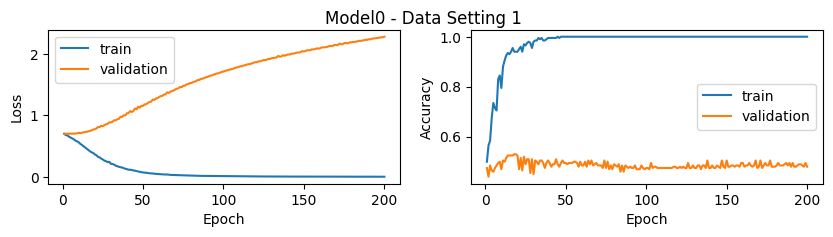

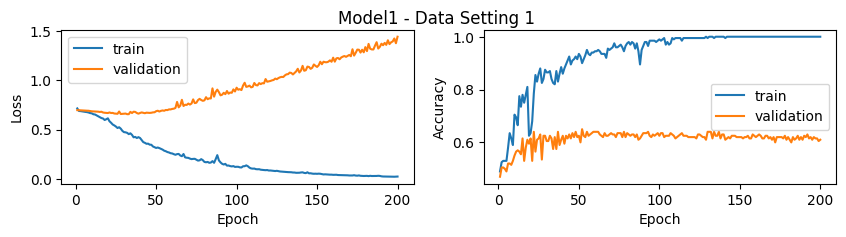

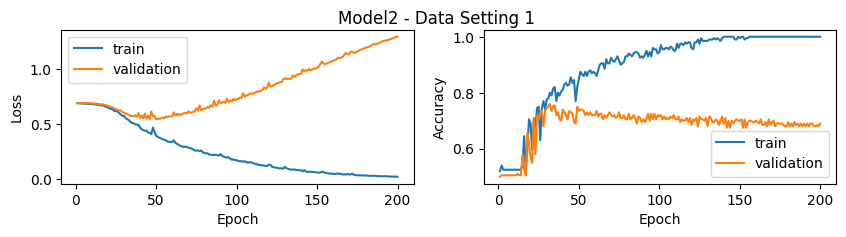

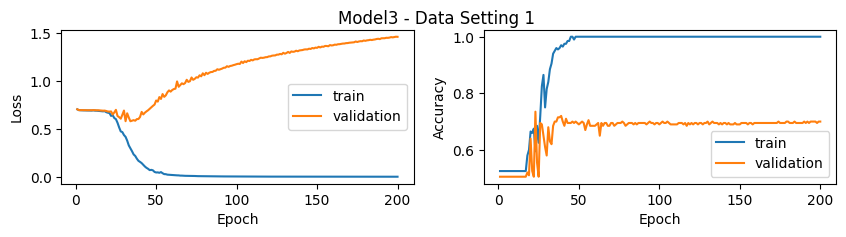

In [21]:
loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid = train("model0Setting1", model0, 
                                                                                   dataLoader_setting1_train,
                                                                                   dataLoader_setting1_validation,
                                                                                   num_epochs = 200)
plotModelPerformance(modelNum = 0, dataSettingNum = 1, loss_hist_train = loss_hist_train, loss_hist_valid = loss_hist_valid, 
                         accuracy_hist_train = accuracy_hist_train, accuracy_hist_valid = accuracy_hist_valid)


loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid = train("model1Setting1", model1, 
                                                                                   dataLoader_setting1_train,
                                                                                   dataLoader_setting1_validation,
                                                                                   num_epochs = 200)
plotModelPerformance(modelNum = 1, dataSettingNum = 1, loss_hist_train = loss_hist_train, loss_hist_valid = loss_hist_valid, 
                         accuracy_hist_train = accuracy_hist_train, accuracy_hist_valid = accuracy_hist_valid)

loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid = train("model2Setting1", model2, 
                                                                                   dataLoader_setting1_train,
                                                                                   dataLoader_setting1_validation,
                                                                                   num_epochs = 200)
plotModelPerformance(modelNum = 2, dataSettingNum = 1, loss_hist_train = loss_hist_train, loss_hist_valid = loss_hist_valid, 
                         accuracy_hist_train = accuracy_hist_train, accuracy_hist_valid = accuracy_hist_valid)

loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid = train("model3Setting1", model3, 
                                                                                   dataLoader_setting1_train,
                                                                                   dataLoader_setting1_validation,
                                                                                   num_epochs = 200)
plotModelPerformance(modelNum = 3, dataSettingNum = 1, loss_hist_train = loss_hist_train, loss_hist_valid = loss_hist_valid, 
                         accuracy_hist_train = accuracy_hist_train, accuracy_hist_valid = accuracy_hist_valid)

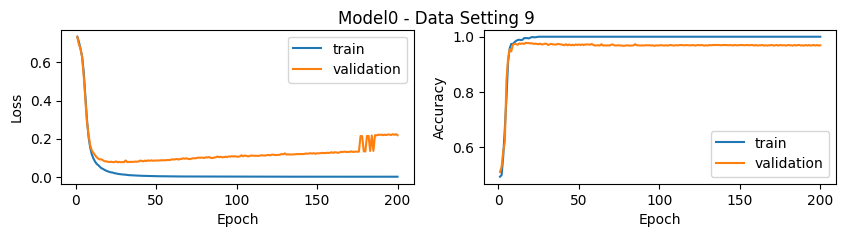

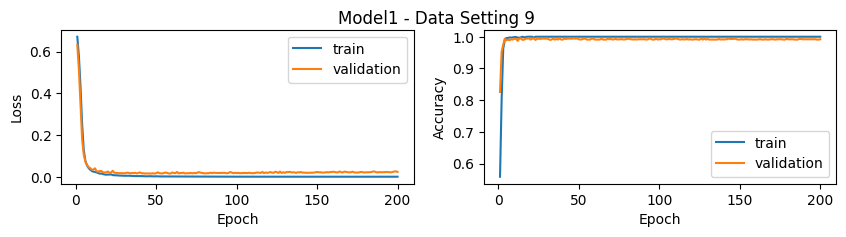

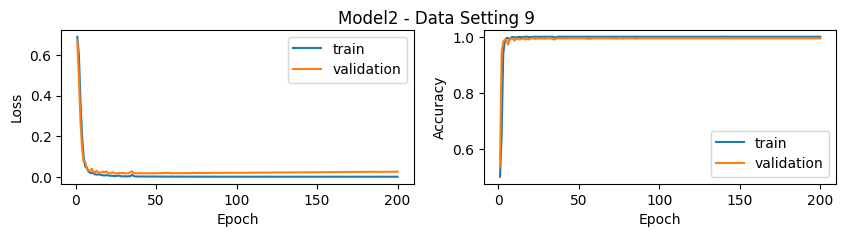

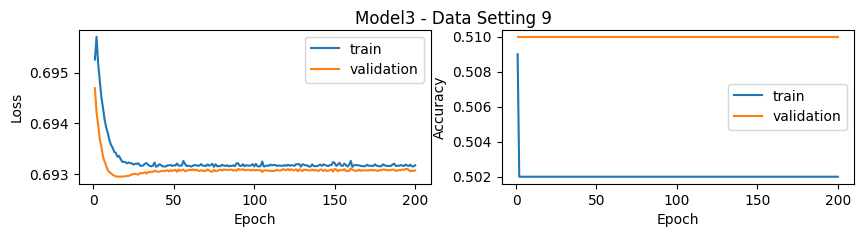

In [22]:
loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid = train("model0Setting9", model0, 
                                                                                   dataLoader_setting9_train,
                                                                                   dataLoader_setting9_validation,
                                                                                   num_epochs = 200)
plotModelPerformance(modelNum = 0, dataSettingNum = 9, loss_hist_train = loss_hist_train, loss_hist_valid = loss_hist_valid, 
                         accuracy_hist_train = accuracy_hist_train, accuracy_hist_valid = accuracy_hist_valid)


loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid = train("model1Setting9", model1, 
                                                                                   dataLoader_setting9_train,
                                                                                   dataLoader_setting9_validation,
                                                                                   num_epochs = 200)
plotModelPerformance(modelNum = 1, dataSettingNum = 9, loss_hist_train = loss_hist_train, loss_hist_valid = loss_hist_valid, 
                         accuracy_hist_train = accuracy_hist_train, accuracy_hist_valid = accuracy_hist_valid)

loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid = train("model2Setting9", model2, 
                                                                                   dataLoader_setting9_train,
                                                                                   dataLoader_setting9_validation,
                                                                                   num_epochs = 200)
plotModelPerformance(modelNum = 2, dataSettingNum = 9, loss_hist_train = loss_hist_train, loss_hist_valid = loss_hist_valid, 
                         accuracy_hist_train = accuracy_hist_train, accuracy_hist_valid = accuracy_hist_valid)

loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid = train("model3Setting1", model3, 
                                                                                   dataLoader_setting9_train,
                                                                                   dataLoader_setting9_validation,
                                                                                   num_epochs = 200)
plotModelPerformance(modelNum = 3, dataSettingNum = 9, loss_hist_train = loss_hist_train, loss_hist_valid = loss_hist_valid, 
                         accuracy_hist_train = accuracy_hist_train, accuracy_hist_valid = accuracy_hist_valid)